In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Set Random Seed
from numpy.random import seed
seed(100)
tf.compat.v1.set_random_seed(100)

In [2]:
# Load dataset
data = pd.read_csv('./mtcars.csv')
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
#Remove Model Column
data=data.drop('model', axis=1)
data.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [4]:
#Create x and y variables
X = data.drop('mpg', axis=1)
y = data['mpg']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train2 = sc.fit_transform(X_train)
X_test2 = sc.transform(X_test)

In [5]:
#Create Base Model

from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
import keras.backend as K

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(8,kernel_initializer='normal', input_shape=[len(X.keys())], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2,seed=100))
    model.add(Dense(2,kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2,seed=100))
    model.add(Dense(1,kernel_initializer='normal'))
    
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss=rmse, optimizer= optimizer, metrics=[rmse])
    return model

Using TensorFlow backend.


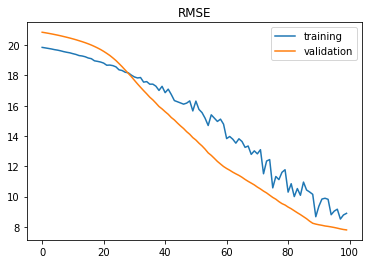


 RMSE Metrics
Train RMSE: 14.42, Validation RMSE: 8.39


In [6]:
#Evaluate Model
model=create_baseline()
early_stop=keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10)
history = model.fit(X_train2,y_train, epochs=100,
                    validation_data=(X_test2, y_test),
                    verbose=0,batch_size = 1,callbacks=[early_stop])

#Plot
def plot_accuracies_and_losses(history):
    plt.title('RMSE')
    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
    
plot_accuracies_and_losses(history)

# Evaluate the model on the test data using `evaluate`
resultsTst = model.evaluate(X_test2, y_test,verbose=0)
resultsTrn = model.evaluate(X_train2, y_train,verbose=0)
print('\n RMSE Metrics')
print('Train RMSE: {:.2f}, Validation RMSE: {:.2f}'.format(resultsTrn[0],resultsTst[0])) 

In [7]:
#Cross Validation of Model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=create_baseline, epochs=100,
                                         batch_size=1, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=100)
results = cross_val_score(pipeline, X, y, cv=kfold)
print('CV-RMSE: {:.2f}'.format(-results.mean()))

CV-RMSE: 18.32
